In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!ls

heart-failure-clinical-data.zip		    my_save_mdl_undersampling.pkl
heart_failure_clinical_records_dataset.csv  oversampledBikeData.pkl
kaggle.json				    SeoulBikeData.csv
my_save_mdl.pkl				    SeoulBikeData.gsheet


In [ ]:
from traitlets import Undefined
import pandas as pd
import numpy as np
missing_value = ["Undefined"]
data = pd.read_csv("SeoulBikeData.csv", encoding_errors='ignore', na_values = missing_value)
data.head() #we wanna use these features to predict if the day is functioning

,Rented Bike Count,Hour,Temperature(蚓),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(蚓),Solar Radiation (MJ/m2),Rainfall(mm),S0wfall (cm),Seasons,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [ ]:
Y = data['Functioning Day']
Y = Y[1:]
X = data.drop(['Holiday'], axis = 1)
X = X[1:]
print(X.shape, Y.shape)

(8759, 12) (8759,)


In [ ]:
data.head()

,Rented Bike Count,Hour,Temperature(蚓),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(蚓),Solar Radiation (MJ/m2),Rainfall(mm),S0wfall (cm),Seasons,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [ ]:
from collections import Counter

original_count = Counter(Y)
print(original_count)


Counter({1: 8464, 0: 295})


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from imblearn.over_sampling import SMOTE #SMOTE is especially good with resampling data size so its fitting for the model and you get 50-50 estimates instead of a skewed dataset.
import numpy as np
over = SMOTE() #Uses neareset neighbor to find a mean that matches with the first one to make a model so that the model will still create a similar shape.
#for date format, divide date into 3 attributes
X_new, Y_new = over.fit_resample(X,Y)
new_counts = Counter(X_new)
print(new_counts)

Counter({'Rented Bike Count': 1, 'Hour': 1, 'Temperature(蚓)': 1, 'Humidity(%)': 1, 'Wind speed (m/s)': 1, 'Visibility (10m)': 1, 'Dew point temperature(蚓)': 1, 'Solar Radiation (MJ/m2)': 1, 'Rainfall(mm)': 1, 'S0wfall (cm)': 1, 'Seasons': 1, 'Functioning Day': 1})


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size = 0.2, random_state = 0)
pca = PCA()
logistic = LogisticRegression(max_iter = 100000, tol = 0.1)
pipe = Pipeline(steps =[('pca', pca), ('logistic', logistic)])

param_grid = {
       'pca__n_components': [2,4,6,8,10,12], #two underscores by pca and two with logistic because of how many are being run.
       'logistic__C': np.logspace(-4,4,6)
}

search = GridSearchCV(pipe, param_grid, n_jobs = -1)
search.fit(x_train, y_train)
print("Best param (CV score = %0.3f:" % search.best_score_)
print(search.best_params_)

Best param (CV score = 1.000:
{'logistic__C': 6.309573444801943, 'pca__n_components': 2}


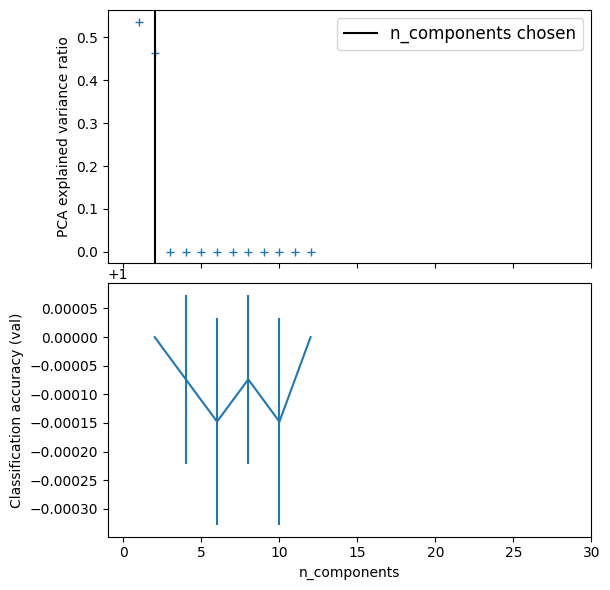

In [ ]:
pca.fit(x_train)
fig, (ax0, ax1) = plt.subplots(nrows = 2,sharex = True, figsize = (6,6))
ax0.plot(np.arange(1,pca.n_components_ + 1), pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle='solid', label = 'n_components chosen', color = 'black' )
ax0.legend(prop=dict(size=12))
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr= 'std_test_score', legend=False, ax = ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.xlim(-1,30)
plt.tight_layout()

In [ ]:
#, LogisticRegressionCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size = 0.2, random_state = 0)

pca = PCA(n_components=8)
stdscl = StandardScaler()
logistic = LogisticRegression(C = 0.15848931924611143, max_iter = 100000, tol = 0.1)
pipe = Pipeline(steps = [('standardscalar', stdscl), ('pca', pca), ('logistic', logistic)])

In [ ]:
my_mdl = pipe.fit(x_train,y_train)
my_mdl.score(x_test,y_test)

1.0

In [ ]:
from joblib import dump, load
dump(my_mdl, 'oversampledBikeData.pkl')

['oversampledBikeData.pkl']

In [ ]:
my_prediction = my_mdl.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, my_prediction, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1701
           1       1.00      1.00      1.00      1685

    accuracy                           1.00      3386
   macro avg       1.00      1.00      1.00      3386
weighted avg       1.00      1.00      1.00      3386



In [ ]:
def prediction(arg1):
  my_mdl = load('oversampledBikeData.pkl')
  my_prediction = my_prediction.predict(arg1)
  return(my_prediction)

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, my_prediction)
print(conf)

[[1701    0]
 [   0 1685]]


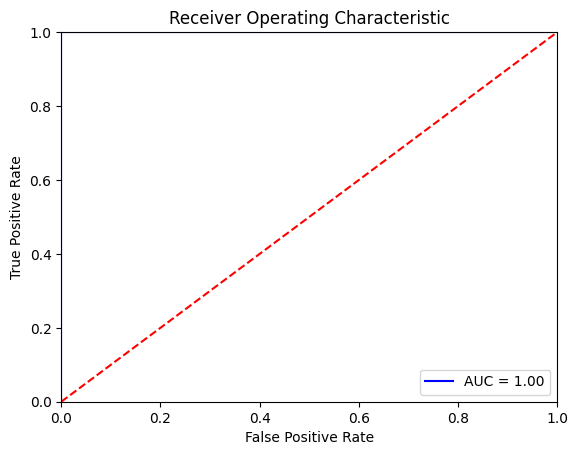

In [ ]:
import sklearn.metrics as metrics
#calculate for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds =  probs[:,1]
fpr, tpr , threshold = metrics.roc_curve(y_test, my_prediction)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#loading the saved model

pkld_model = load("oversampledBikeData.pkl")
my_prediction = pkld_model.predict(x_test)
print(classification_report(y_test, my_prediction, target_names= ['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1701
           1       1.00      1.00      1.00      1685

    accuracy                           1.00      3386
   macro avg       1.00      1.00      1.00      3386
weighted avg       1.00      1.00      1.00      3386

